In [3]:
def download_dataset():
  # set up kaggle api and credentials
  ! pip install -q kaggle
  from google.colab import files
  files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  # download the dataset
  !kaggle datasets download -d 'tanlikesmath/diabetic-retinopathy-resized'
  #unzip
  !mkdir diabetic-retinopathy-resized
  !unzip diabetic-retinopathy-resized.zip -d diabetic-retinopathy-resized
  !mv ./* diabetic-retinopathy-resized

In [4]:
import os
dataset_dir_exist = os.path.isdir('diabetic-retinopathy-resized')
if not dataset_dir_exist:
  print('downloading dataset')
  download_dataset()

downloading dataset


Streaming output truncated to the last 5000 lines.
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44261_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44261_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44262_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44262_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44263_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44263_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44264_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44264_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44265_left.jpeg  
  inflati

In [5]:
import numpy as np
import pandas as pd
import os

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split

In [7]:
path = "diabetic-retinopathy-resized/resized_train/resized_train"

In [8]:
print('number of images in total - ',len(os.listdir(path)))

number of images in total -  35126


In [9]:
labels = pd.read_csv("diabetic-retinopathy-resized/trainLabels.csv") 
print('number of images in total - ',len(labels))

number of images in total -  35126


In [10]:
labels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [12]:
#format correctly
labels['image_name'] = [i+".jpeg" for i in labels['image'].values]

labels.head(10)

,image,level,image_name
0,10_left,0,10_left.jpeg
1,10_right,0,10_right.jpeg
2,13_left,0,13_left.jpeg
3,13_right,0,13_right.jpeg
4,15_left,1,15_left.jpeg
5,15_right,2,15_right.jpeg
6,16_left,4,16_left.jpeg
7,16_right,4,16_right.jpeg
8,17_left,0,17_left.jpeg
9,17_right,1,17_right.jpeg


In [13]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       35126 non-null  object
 1   level       35126 non-null  int64 
 2   image_name  35126 non-null  object
dtypes: int64(1), object(2)
memory usage: 823.4+ KB


(683, 1024, 3)

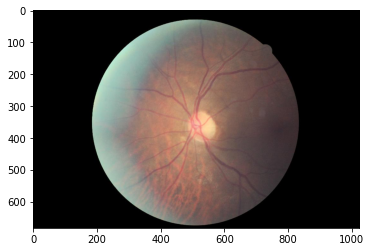

In [14]:
plt.imshow(plt.imread(path + '/' + labels['image_name'][0]))
plt.imread(path + '/' + labels['image_name'][0]).shape

In [15]:
train, val = train_test_split(labels, test_size=0.2,random_state=42,stratify=labels["level"])
train.shape, val.shape


((28100, 3), (7026, 3))

In [16]:
train_datagen = ImageDataGenerator(rescale            = 1/255,
                                   shear_range        = 0.2,
                                   zoom_range         = 0.2,
                                   horizontal_flip    = True,
                                   rotation_range     = 40,
                                   width_shift_range  = 0.2,
                                   height_shift_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1/255)

In [17]:
train_set = train_datagen.flow_from_dataframe(
    train,
    path,
    x_col="image_name",
    y_col="level",
    class_mode="raw",
    color_mode="rgb",
    batch_size=32,
    target_size=(64, 64))

val_set = val_datagen.flow_from_dataframe(
    val,
    path,
    x_col="image_name",
    y_col="level",
    class_mode="raw",
   color_mode="rgb",
    batch_size=32,
    target_size=(64, 64))

Found 28100 validated image filenames.
Found 7026 validated image filenames.


In [46]:
model = Sequential()

model.add(Conv2D(filters = 128, kernel_size = (5, 5), padding = "same", input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = "same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 32, kernel_size =  (5, 5), padding = "same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation = 'softmax'))

In [47]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 64, 64, 128)       9728      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 21, 21, 128)      0         
 g2D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 21, 21, 128)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 21, 21, 64)        204864    
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 7, 7, 64)        

In [54]:
model_train = model.fit(
    train_set,
    #steps_per_epoch = 200,
    epochs = 5,
    validation_data = val_set,
    verbose=1
   # validation_steps = 100
)

Epoch 1/5
879/879 [==============================] - 872s 991ms/step - loss: 0.8994 - accuracy: 0.7337 - val_loss: 0.8750 - val_accuracy: 0.7347
Epoch 2/5
879/879 [==============================] - 872s 992ms/step - loss: 0.8821 - accuracy: 0.7348 - val_loss: 0.8666 - val_accuracy: 0.7347
Epoch 3/5
879/879 [==============================] - 866s 985ms/step - loss: 0.8764 - accuracy: 0.7348 - val_loss: 0.8771 - val_accuracy: 0.7347
Epoch 4/5
879/879 [==============================] - 868s 987ms/step - loss: 0.8730 - accuracy: 0.7348 - val_loss: 0.8767 - val_accuracy: 0.7347
Epoch 5/5
879/879 [==============================] - 858s 976ms/step - loss: 0.8723 - accuracy: 0.7348 - val_loss: 0.8671 - val_accuracy: 0.7347


# Data Visualization

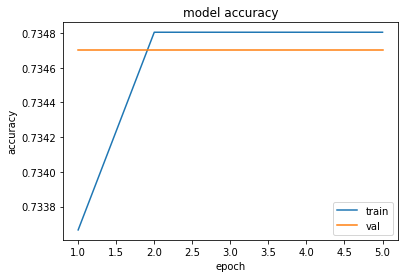

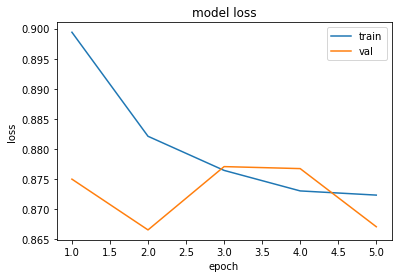

In [55]:
epochs=range(1,len(model_train.history['val_loss'])+1)

plt.title('model accuracy')
plt.plot(epochs,model_train.history['accuracy'])
plt.plot(epochs,model_train.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

plt.plot(epochs,model_train.history['loss'])
plt.plot(epochs,model_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()